<a href="https://colab.research.google.com/github/talha-q/talha_Geo6805/blob/main/Lab_3_Resnet50_Talha(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
from osgeo import gdal
import pickle
import random


Checking libraries

In [3]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


Code for loading Custom Dataset (RS data)

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, img_transform=None, sensor=None):
        self.img_dir = img_dir
        self.img_transform = img_transform
        self.sensor = sensor

        self.tif_files = sorted(glob(os.path.join(self.img_dir, "**", "*.[tT][iI][fF]"), recursive=True))
        sub_folders = sorted(
            class_name for class_name in os.listdir(self.img_dir)
            if os.path.isdir(os.path.join(self.img_dir, class_name))
        )
        self.sub_folder_dict = {class_name: index for index, class_name in enumerate(sub_folders)}

    def __len__(self):
        return len(self.tif_files)

    def __getitem__(self, idx):
        img_path = self.tif_files[idx]
        image_file = gdal.Open(img_path)

        if self.sensor == 'rgb':
            band_r = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_g = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            band_b = image_file.GetRasterBand(3).ReadAsArray().astype(np.float32)
            image = np.stack([band_r, band_g, band_b], axis=0)
        elif self.sensor == 'planet':
            band_r = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_g = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            band_b = image_file.GetRasterBand(3).ReadAsArray().astype(np.float32)
            band_nir = image_file.GetRasterBand(4).ReadAsArray().astype(np.float32)
            image = np.stack([band_r, band_g, band_b, band_nir], axis=0)
        elif self.sensor == 's1':
            band_vv = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_vh = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            image = np.stack([band_vv, band_vh], axis=0)
        else:
            raise ValueError(f"Sensor {self.sensor} not supported")

        if self.img_transform:
            image = self.img_transform(image)

        label = self.sub_folder_dict[Path(img_path).parts[-2]]
        return image, label


# Assignment 1 Custom Z Score

In [6]:
#Loading the data
data_path = "/content/drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images"
data = CustomImageDataset(data_path, sensor='rgb')
print(data)
print(len(data))
print(data[0])

2106
(array([[[ 44.,  53.,  47., ..., 125., 137., 119.],
        [ 41.,  46.,  44., ...,  83., 124., 135.],
        [ 42.,  44.,  43., ...,  90.,  99., 101.],
        ...,
        [175., 190., 223., ..., 144., 135., 124.],
        [120., 151., 168., ..., 123., 126., 133.],
        [128., 113., 122., ..., 101.,  99., 135.]],

       [[ 41.,  50.,  44., ..., 126., 137., 119.],
        [ 38.,  43.,  41., ...,  83., 124., 131.],
        [ 39.,  41.,  40., ...,  95., 103.,  99.],
        ...,
        [173., 191., 223., ..., 144., 135., 123.],
        [113., 147., 166., ..., 121., 121., 129.],
        [118., 103., 114., ..., 101.,  95., 129.]],

       [[ 45.,  56.,  50., ..., 122., 130., 111.],
        [ 42.,  46.,  45., ...,  81., 118., 126.],
        [ 43.,  44.,  44., ...,  91.,  98.,  97.],
        ...,
        [175., 189., 221., ..., 136., 126., 118.],
        [120., 150., 165., ..., 117., 117., 124.],
        [127., 110., 118., ...,  99.,  94., 127.]]], dtype=float32), 0)


Randomly selecting training data from the dataset, Using 30 percent of the total dataset.

In [7]:
# using random seed so we get the same random set everytime
random.seed("seed1")
samplesize = int(0.3 * len(data))

print(f"****Random Sample Data****\nselecting 30% from the dataset of {len(data)}\nSample size for training is {samplesize}\n")
sampleidx = random.sample(range(len(data)), samplesize)
print(f"***Randomly sampled {samplesize} indices from dataset***\n{sampleidx}")


****Random Sample Data****
selecting 30% from the dataset of 2106
Sample size for training is 631

***Randomly sampled 631 indices from dataset***
[709, 2041, 1401, 1570, 1002, 1960, 1372, 279, 81, 946, 421, 332, 834, 147, 121, 2099, 771, 2062, 50, 189, 1073, 1725, 1225, 800, 1487, 1553, 510, 1993, 200, 1686, 907, 966, 1140, 1078, 1787, 625, 634, 1468, 289, 1139, 275, 405, 140, 1910, 413, 546, 725, 462, 1625, 1486, 1733, 1383, 82, 1492, 1183, 324, 813, 1293, 1659, 1283, 868, 1366, 66, 1211, 639, 465, 1828, 1013, 1629, 399, 1395, 754, 1272, 1107, 812, 901, 1797, 633, 789, 406, 1842, 1467, 1, 337, 2083, 1432, 1413, 1510, 710, 149, 300, 1095, 2001, 829, 1982, 1400, 1017, 1517, 209, 1815, 930, 1090, 1716, 762, 643, 1965, 1202, 561, 737, 491, 1471, 1346, 1150, 1349, 1766, 745, 931, 277, 1585, 910, 418, 524, 349, 226, 461, 1578, 2100, 2065, 667, 700, 956, 1859, 1154, 1864, 452, 785, 1218, 1677, 88, 2056, 1866, 916, 1209, 1776, 323, 280, 407, 1415, 2037, 1390, 875, 502, 1934, 548, 603, 1752, 

In [8]:
print(type(data))
sample_data = [data[i] for i in tqdm(sampleidx, desc="Sampling data")]


<class '__main__.CustomImageDataset'>


Sampling data:   0%|          | 0/631 [00:00<?, ?it/s]

In [9]:
# image, _ = sample_data[0]
# print(image.shape)
# print(range(image.shape[0])) basically the same thing as num_bands below.

In [10]:
num_bands = sample_data[0][0].shape[0] #number of bands  in the sampled data
print(f"Number of bands in the sampled data: {num_bands}")

#Creating an empty list to flatten and store the bands
flatnBandList=[]
flatnBandList = [[] for i in range(num_bands)]
print(flatnBandList)

# Loop over each sample in the dataset
for sample in tqdm(sample_data, desc="Flattening and Storing Bands"):
    image, _ = sample  # unpack image and ignore label
    for i in range(num_bands):
        flatnBandList[i].append(image[i].flatten())
print(len(flatnBandList))

Number of bands in the sampled data: 3
[[], [], []]


Flattening and Storing Bands:   0%|          | 0/631 [00:00<?, ?it/s]

3


In [11]:
means = []
stds = []
abs_means = []
abs_stds = []

for band_values in flatnBandList:
    # Convert each array in the band to a float32 tensor
    tensors = [torch.tensor(arr, dtype=torch.float32) for arr in band_values]

    # Concatenate all tensors into one long 1D tensor
    all_pixels = torch.cat(tensors)

    # Compute raw mean and std
    means.append(all_pixels.mean().item())
    stds.append(all_pixels.std().item())

    # Compute absolute mean and std (optional, if required)
    abs_pixels = torch.abs(all_pixels)
    abs_means.append(abs_pixels.mean().item())
    abs_stds.append(abs_pixels.std().item())

print("Band-wise means:", means)
print("Band-wise stds:", stds)
print("Absolute Band-wise means:", abs_means)
print("Absolute Band-wise stds:", abs_stds)

stats = {
    "means": means,
    "stds": stds
}

# Save to file
with open("band_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

print(f"Band Stat Pickle file loaded successfully. Loaded stats: {loaded_stats}")


Band-wise means: [122.29977416992188, 124.45809936523438, 114.83135986328125]
Band-wise stds: [56.0106315612793, 51.57552719116211, 49.975303649902344]
Absolute Band-wise means: [122.29977416992188, 124.45809936523438, 114.83135986328125]
Absolute Band-wise stds: [56.0106315612793, 51.57552719116211, 49.975303649902344]
Band Stat Pickle file loaded successfully. Loaded stats: {'means': [122.29977416992188, 124.45809936523438, 114.83135986328125], 'stds': [56.0106315612793, 51.57552719116211, 49.975303649902344]}


Custom Transformation

In [12]:
from torchvision.transforms import v2

class CustomAugmentation:
    def __init__(self, resize_size=(256, 256), crop_size=(224, 224),
                 do_resize=True, do_random_crop=True, do_horizontal_flip=True, do_random_hue=True):
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.do_resize = do_resize
        self.do_random_crop = do_random_crop
        self.do_horizontal_flip = do_horizontal_flip
        self.do_random_hue = do_random_hue

    def __call__(self, image):
        if self.do_resize:
            image = v2.functional.resize(image, self.resize_size, antialias=True)

        if self.do_random_crop:
            _, height, width = image.shape
            crop_height, crop_width = self.crop_size
            top = torch.randint(0, height - crop_height + 1, (1,)).item()
            left = torch.randint(0, width - crop_width + 1, (1,)).item()
            image = v2.functional.crop(image, top, left, crop_height, crop_width)

        if self.do_horizontal_flip and torch.rand(1) > 0.5:
            image = v2.functional.horizontal_flip(image)

        if self.do_random_hue and torch.rand(1) > 0.5 and image.shape[0] >= 3:
            image[:3] = v2.functional.adjust_hue(image[:3], torch.empty(1).uniform_(-0.1, 0.1).item())

        return image




Z Score Normalization
`

In [13]:
# Load from pickle
with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1) #(C,W,H)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)

# Final transformation pipeline
custom_transform = transforms.Compose([
    lambda x: torch.from_numpy(x).float(),
    CustomAugmentation(resize_size=(256, 256), crop_size=(224, 224), do_random_hue=False),
    z_score_form_stats(mean=loaded_stats["means"], std=loaded_stats["stds"])
])


#Assignment2 Resnet 50

In [15]:
# Apply the final transform to full dataset
data_path = r"/content/drive/My Drive/UCMerced_LandUse/UCMerced_LandUse/Images"

mydataset_full = CustomImageDataset(data_path, img_transform=custom_transform, sensor='rgb')
print(len(mydataset_full))
print(mydataset_full[1])

# Split sizes
train_size = int(0.7 * len(mydataset_full))
val_size   = int(0.1 * len(mydataset_full))
test_size  = len(mydataset_full) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(mydataset_full, [train_size, val_size, test_size])

# Save paths
train_paths = [mydataset_full.tif_files[i] for i in train_dataset.indices]
val_paths   = [mydataset_full.tif_files[i] for i in val_dataset.indices]
test_paths  = [mydataset_full.tif_files[i] for i in test_dataset.indices]

splits_dict = {
    "train_paths": train_paths,
    "val_paths": val_paths,
    "test_paths": test_paths
}

with open("splits.pkl", "wb") as f:
    pickle.dump(splits_dict, f)

# To reload:
with open("splits.pkl", "rb") as f:
    loaded_splits = pickle.load(f)

print("Train:", len(loaded_splits["train_paths"]))
print("Validation:", len(loaded_splits["val_paths"]))
print("Test:", len(loaded_splits["test_paths"]))


2106
(tensor([[[-0.1303, -0.2017, -0.3089,  ...,  0.2982,  0.0125,  0.0661],
         [ 0.1375,  0.1018, -0.0232,  ..., -0.4517, -0.0232,  0.4946],
         [ 0.0304,  0.1553,  0.2089,  ..., -0.4338, -0.4695, -0.1303],
         ...,
         [ 0.0125, -0.0054, -0.1303,  ...,  0.2446, -0.1303, -0.0946],
         [ 0.1196, -0.0054, -0.3803,  ...,  0.2446,  0.1018,  0.0661],
         [ 0.4767,  0.0839,  0.0482,  ..., -0.4874, -0.2017,  0.2803]],

        [[-0.1446, -0.1252, -0.2609,  ...,  0.2044, -0.1252, -0.0477],
         [ 0.0881,  0.0881, -0.0477,  ..., -0.5518, -0.1252,  0.4177],
         [-0.0089,  0.1462,  0.1656,  ..., -0.4742, -0.5324, -0.1834],
         ...,
         [ 0.0105,  0.0687, -0.1446,  ...,  0.1462, -0.2803, -0.1058],
         [ 0.0493, -0.0477, -0.4354,  ...,  0.0881, -0.0670, -0.0089],
         [ 0.3595, -0.0477, -0.0670,  ..., -0.7263, -0.3967,  0.1268]],

        [[-0.1167, -0.1367, -0.2167,  ...,  0.3235,  0.0034,  0.0834],
         [ 0.1234,  0.1034,  0.0034,  .

**********************************************************************
*********************************************************************
***********************************************************************

##Bottleneck and Resnet 50

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Bottleneck block for ResNet-50/101/152
class Bottleneck(nn.Module):
    expansion = 4  # Output channels are multiplied by this factor

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# ResNet-50 model
class ResNet50(nn.Module):
    def __init__(self, num_classes=None):
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(Bottleneck, 64, blocks=3)
        self.layer2 = self._make_layer(Bottleneck, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example: Instantiate model for UCMerced (21 classes)
model = ResNet50(num_classes=21)
print(model)


ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

##Training and Validation

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer, scheduler
model = ResNet50(num_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# For tracking
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None

# Training loop
for epoch in range(1, 61):  # 60 epochs
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch:02d}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

    scheduler.step()




Epoch 01: Train Loss = 2.6310, Val Loss = 4.0806
Epoch 02: Train Loss = 2.0109, Val Loss = 1.8894
Epoch 03: Train Loss = 1.6602, Val Loss = 1.5585
Epoch 04: Train Loss = 1.3500, Val Loss = 1.1539
Epoch 05: Train Loss = 1.2520, Val Loss = 1.4667
Epoch 06: Train Loss = 1.1643, Val Loss = 1.0282
Epoch 07: Train Loss = 1.0510, Val Loss = 1.2588
Epoch 08: Train Loss = 0.9955, Val Loss = 0.8560
Epoch 09: Train Loss = 0.9727, Val Loss = 1.3262
Epoch 10: Train Loss = 0.8778, Val Loss = 1.1359
Epoch 11: Train Loss = 0.8048, Val Loss = 0.7842
Epoch 12: Train Loss = 0.8034, Val Loss = 0.8054
Epoch 13: Train Loss = 0.6307, Val Loss = 0.7035
Epoch 14: Train Loss = 0.5596, Val Loss = 0.9443
Epoch 15: Train Loss = 0.5627, Val Loss = 1.3999
Epoch 16: Train Loss = 0.6030, Val Loss = 0.7420
Epoch 17: Train Loss = 0.6438, Val Loss = 0.5763
Epoch 18: Train Loss = 0.4565, Val Loss = 0.8396
Epoch 19: Train Loss = 0.5504, Val Loss = 0.8030
Epoch 20: Train Loss = 0.5208, Val Loss = 0.7117
Epoch 21: Train Loss

##Training Results

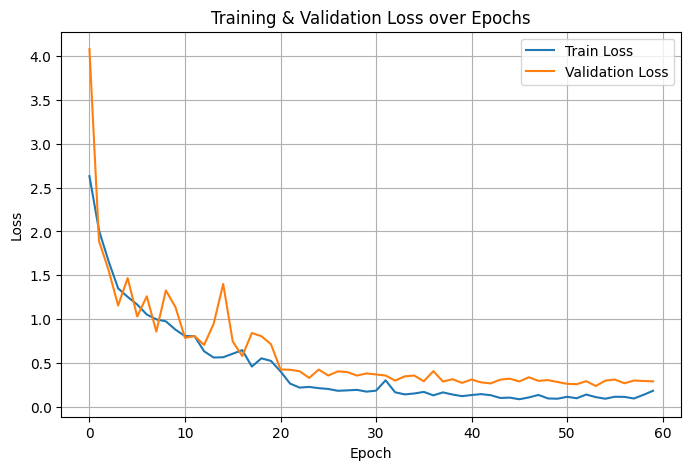

In [18]:
# Load best model
model.load_state_dict(best_model_state)

# Plot train/val loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

##Model Evaluation

In [19]:
# Test evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {test_accuracy:.2f}%")



✅ Final Test Accuracy: 87.91%


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names (if available)
# Example: class_names = mydataset_full.classes or your label encoder classes
class_names = [str(i) for i in range(21)]  # Replace with actual class names if you have them

# Generate report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
print("\n📊 Classification Report:\n")
print(report)



📊 Classification Report:

              precision    recall  f1-score   support

           0      0.864     0.950     0.905        20
           1      1.000     0.952     0.976        21
           2      1.000     0.929     0.963        14
           3      1.000     1.000     1.000        24
           4      0.667     0.526     0.588        19
           5      0.913     1.000     0.955        21
           6      0.889     0.762     0.821        21
           7      0.947     0.857     0.900        21
           8      0.913     0.913     0.913        23
           9      0.800     0.960     0.873        25
          10      0.947     1.000     0.973        18
          11      0.857     0.857     0.857        14
          12      0.667     1.000     0.800        10
          13      0.882     0.882     0.882        17
          14      0.875     0.933     0.903        15
          15      1.000     0.957     0.978        23
          16      0.962     1.000     0.980        25


In [21]:
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Round values for better readability
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].round(3)

# Display
print("\n📋 Classification Report Table:")
display(report_df)



📋 Classification Report Table:


,precision,recall,f1-score,support
0,0.864,0.950,0.905,20.000000
1,1.000,0.952,0.976,21.000000
2,1.000,0.929,0.963,14.000000
3,1.000,1.000,1.000,24.000000
4,0.667,0.526,0.588,19.000000
5,0.913,1.000,0.955,21.000000
6,0.889,0.762,0.821,21.000000
7,0.947,0.857,0.900,21.000000
8,0.913,0.913,0.913,23.000000
9,0.800,0.960,0.873,25.000000


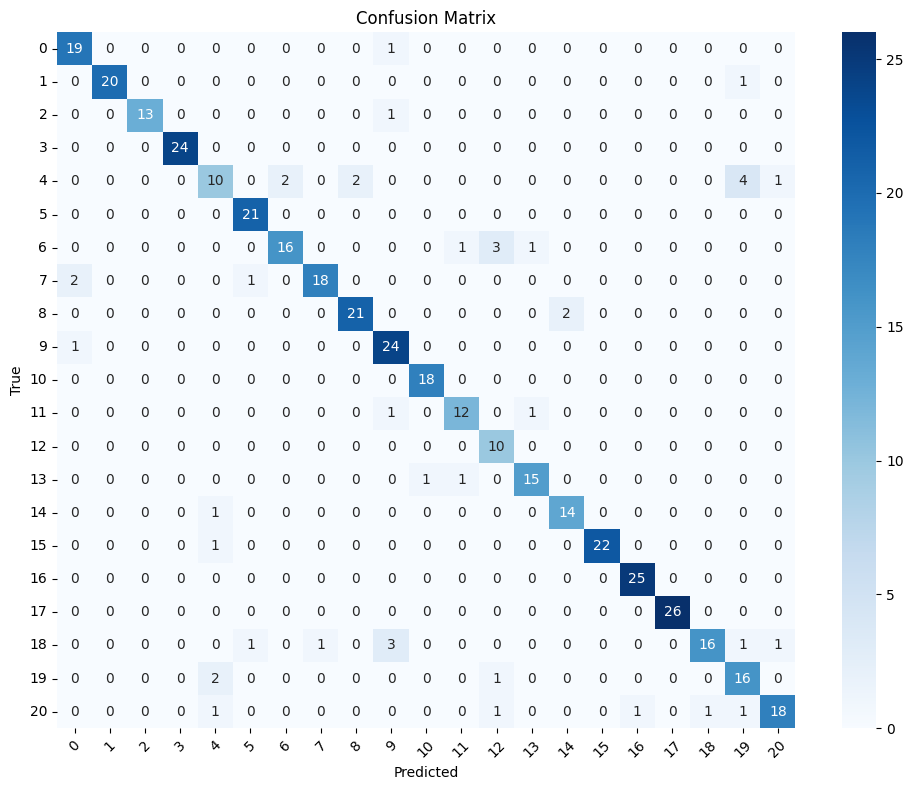

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()